In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import numpy as np
import math
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from skimage.filters import threshold_otsu
from datetime import datetime
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
import seaborn as sns
import src.stimuli_timeline as st
import src.plotting as plott
from IPython.display import display, HTML
display(HTML("<style>.output_scroll {height: 500px; overflow-y: scroll;}</style>"))

plt.style.use('default')
plt.rc('axes.spines', bottom=True, left=True, right=False, top=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Experiment config
# Defines run-specific parameters: fish/experiment IDs, FPS, planes, stimulus labels/colors, pre/post windows, and filename prefixes.
fish_id = "L433_f02"  # 👈 just change this
experiment_name = 'Exp_1_flickering'  # 👈 just change this
fish = f"{fish_id}_{experiment_name}"
#stimuli path
#stimuli_path = Path(r"\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\CIG\jlarsch\default\D2c\Alejandro\2p\flickering\stimuli")
stimuli_main_path = Path(r"\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\CIG\jlarsch\default\D2c\Alejandro\2p")
stimuli_path =  stimuli_main_path / experiment_name  / "stimuli"
#experiment path
main_path = Path(r"C:\Users\suribear\OneDrive - Université de Lausanne\Lab\Data\2p")
# --- FIND THE CORRECT LOG FILE ---
metadata_dir = main_path / fish / "01_raw" / "2p" / "metadata"
# deltaF/F path
dfof_dir= main_path / fish / "03_analysis" / "functional" / "suite2P" / "merged_dFoF"
# plots saving path
plots_path = main_path / fish / "03_analysis" / "functional" / "plots" / "stimuli_selected_dFoF"

prefix = "_".join(fish.split("_")[:2])

In [4]:
# Load deltaF/F data
c = [p for p in dfof_dir.glob("*.npy") if "dfof_merged" in p.name.lower()]
dfof = np.load(c[0])
# print("✅ Loaded:", dfof)

print("Shape:", dfof.shape)

Shape: (3340, 1984)


In [5]:
# Inputs
fps_2p = 2
selected_blocks = [f'B{n}' for n in range(1, 3)]
FPS_stimuli = 60
# number of frames from dfof
frames_per_block = dfof.shape[0] / len(selected_blocks)
duration_2p_block_sec = frames_per_block / fps_2p


In [6]:
stimuli_durations = {}

for stim_file in stimuli_path.glob("*trajectory.*"):
    filename = stim_file.stem  # e.g., 'FL2_trajectory'
    stim_name = filename.replace("_trajectory", "")  # e.g., 'FL2'

    if any(s in filename for s in ("B", "RR", "RL")):
        stimuli_durations[stim_name] = st.get_stimulus_timing(stim_file)
    else:
        stimuli_durations[stim_name] = st.get_radius_timing(stim_file)
#
# for stim_file in stimuli_path.glob("*trajectory.*"):
#     filename = stim_file.stem  # e.g., 'FL2_trajectory'
#     stim_name = filename.replace("_trajectory", "")  # e.g., 'FL2'
#
#     stimuli_durations[stim_name] = st.get_stimulus_timing(stim_file)

def transform_stimuli_duration(d):
    out = {}
    for k, v in d.items():
        total_sec = v.get('total_sec', 0)
        static_before = v.get('static_before_sec', 0)
        total_frames = v.get('total_frames', v.get('motion_end_frame'))

        new_v = v.copy()
        new_v['motion_sec'] = round(total_sec - static_before, 3)
        new_v['static_after_sec'] = 0
        if total_frames is not None:
            new_v['motion_end_frame'] = total_frames
            new_v['end_frame'] = total_frames
        out[k] = new_v
    return out

new_data = transform_stimuli_duration(stimuli_durations)
#print(new_data)

In [8]:
# build stimulus traces aligned to 2P time
# Reads the block-log CSV, time-shifts selected blocks to a common 2P timeline, and generates binary time series for each requested trace using per-stimulus durations.

# find all CSVs that end with "block_log.csv"
stimuli_durations=new_data #updates stimuli_durations to the transformed new_data from earlier
block_logs = list(metadata_dir.glob("*block_log.csv"))

# upload block_logs
if not block_logs:
    raise FileNotFoundError(f"No '*block_log.csv' file found in {metadata_dir}")
elif len(block_logs) > 1:
    print("⚠️ Multiple block log files found, using the most recent one:")
    for f in block_logs:
        print(" -", f.name)
    # sort by modification time and pick the newest
    block_logs.sort(key=lambda p: p.stat().st_mtime, reverse=True)

experiment_log_path = block_logs[0]
print("✅ Using block log:", experiment_log_path)

adjusted_log, stimuli_trace_60, stimuli_table, stimuli_id_map   = st.make_stimulus_traces_2(
    experiment_log_path,
    stimuli_durations,
    selected_blocks,
    duration_2p_block_sec
)

cell_traces=dfof.T # shape (n_neurons, T)
n_neurons, T = cell_traces.shape

t_2p_sec = np.arange(T) / float(fps_2p)        # [0, 0.5, 1.0, ..., 1669.5] seconds
idx60 = np.floor(t_2p_sec * 60.0).astype(int)     # map to 60 Hz indices
idx60 = np.clip(idx60, 0, len(stimuli_trace_60) - 1)  # clamp to valid range
stimuli_trace = stimuli_trace_60[idx60]


✅ Using block log: C:\Users\suribear\OneDrive - Université de Lausanne\Lab\Data\2p\L433_f02_Exp_1_flickering\01_raw\2p\metadata\2025-08-05-1506_L433_f02_block_log.csv


In [9]:
def intervals_from_labels(labels, fps, name_by_id=None):
    """
    labels: 1D int array (T,), 0=no stim; >0 = stim id
    fps: sampling rate of labels (e.g., fps_2p = 2.0)
    name_by_id: optional dict {id:int -> name:str}
    """
    labels = np.asarray(labels, dtype=int)
    T = labels.size

    # detect boundaries
    prev = np.concatenate(([0], labels[:-1]))
    change_idx = np.where(labels != prev)[0]

    rows = []
    open_id = 0
    open_start = None

    for i in change_idx:
        curr_id = labels[i]
        # close previous segment if one was open
        if open_id != 0 and open_start is not None:
            onset_f = open_start
            offset_f = i              # exclusive
            rows.append({
                "stimulus_id": open_id,
                "stimulus_name": name_by_id.get(open_id, str(open_id)) if name_by_id else open_id,
                "onset_frame": onset_f,
                "offset_frame": offset_f,
                "onset_time_s": onset_f / fps,
                "offset_time_s": offset_f / fps,
                "duration_frames": offset_f - onset_f,
                "duration_s": (offset_f - onset_f) / fps,
            })
        # start new segment if non-zero
        if curr_id != 0:
            open_id = curr_id
            open_start = i
        else:
            open_id = 0
            open_start = None

    # close a segment that runs to the end
    if open_id != 0 and open_start is not None:
        onset_f = open_start
        offset_f = T
        rows.append({
            "stimulus_id": open_id,
            "stimulus_name": name_by_id.get(open_id, str(open_id)) if name_by_id else open_id,
            "onset_frame": onset_f,
            "offset_frame": offset_f,
            "onset_time_s": onset_f / fps,
            "offset_time_s": offset_f / fps,
            "duration_frames": offset_f - onset_f,
            "duration_s": (offset_f - onset_f) / fps,
        })

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["onset_frame", "stimulus_id"]).reset_index(drop=True)
    return df

# ---- use it ----
# stimuli_trace is your 2 Hz vector built with idx60 mapping
# fps_2p = 2.0
# Optional: if you have stim_id_map like {"RL3":1, "RB":2, ...}
# name_by_id = {v:k for k,v in stim_id_map.items()}
name_by_id = None

table = intervals_from_labels(stimuli_trace, fps=fps_2p, name_by_id=name_by_id)
print(table.head())


   stimulus_id  stimulus_name  onset_frame  offset_frame  onset_time_s  \
0            6              6           26            58          13.0   
1            9              9          109           141          54.5   
2            7              7          192           224          96.0   
3            8              8          275           308         137.5   
4            3              3          358           391         179.0   

   offset_time_s  duration_frames  duration_s  
0           29.0               32        16.0  
1           70.5               32        16.0  
2          112.0               32        16.0  
3          154.0               33        16.5  
4          195.5               33        16.5  


In [10]:
# peri-stimulus window in seconds
t_pre_s  = 5.0   # time before onset to include
t_post_s = 29.0  # time after onset to include

# convert to frames
pre_frames  = int(round(t_pre_s * fps_2p))
post_frames = int(round(t_post_s * fps_2p))
win_lenght = pre_frames + post_frames

# list which stimulus IDs are present in the trace (excluding 0)
stimuli_ids = sorted(int(x) for x in np.unique(stimuli_trace) if x != 0)
stimuli_names = list(stimuli_id_map.keys())

# sanity checks
assert cell_traces.ndim == 2, "traces must be (n_neurons, T)"
assert stimuli_trace.ndim == 1, "stim_trace must be (T,)"
assert cell_traces.shape[1] == stimuli_trace.shape[0], "time dimension mismatch"


print(f"Number of neurons: {n_neurons}")
print(f"Number of time points: {T}")
print("2p duration (s):", T/ fps_2p)               # 1670.0
print("60Hz duration from data (s):", len(stimuli_trace_60) / 60.0)  # ~1665.64
print("Output shape:", stimuli_trace.shape)         # (3340,)
assert stimuli_trace.ndim == 1 and len(stimuli_trace) == T


Number of neurons: 1984
Number of time points: 3340
2p duration (s): 1670.0
60Hz duration from data (s): 1665.6333333333334
Output shape: (3340,)


In [11]:
# take traces when the stimuli are presented, and some frames before and after
onsets_by_id = {}
trial_aligned_traces = {}   # sid -> (n_neurons, win_lenght, n_trials)
# n_trials_by_id = {}
# dropped_onsets_by_id = {}

for stim in stimuli_ids:
    # find onsets frames (0→1 transitions)
    active = (stimuli_trace == stim).astype(np.int8)
    transitions = np.diff(active, prepend=0)
    onsets = np.flatnonzero(transitions == 1)
    onsets_by_id[stim] = onsets

    # create windows and slices neuron trace to generate
    starts = onsets - pre_frames
    ends   = onsets + post_frames
    keep   = (starts >= 0) & (ends <= T)

    # arr is trial-aligned neural activity windows for each stimulus
    # arr shape: (n_neurons, win_length, n_trials)
    if not np.any(keep):
        arr = np.empty((n_neurons, win_lenght, 0), dtype=float)
    else:
        arr = np.stack([cell_traces[:, s:e] for s, e in zip(starts[keep], ends[keep])], axis=2)

    trial_aligned_traces[stim] = arr

    print(f"stim {stim}: {onsets.size} onsets | kept {arr.shape[2]} trials | dropped {np.count_nonzero(~keep)}")

stim 1: 4 onsets | kept 4 trials | dropped 0
stim 2: 4 onsets | kept 4 trials | dropped 0
stim 3: 4 onsets | kept 4 trials | dropped 0
stim 4: 4 onsets | kept 4 trials | dropped 0
stim 5: 4 onsets | kept 4 trials | dropped 0
stim 6: 4 onsets | kept 4 trials | dropped 0
stim 7: 4 onsets | kept 4 trials | dropped 0
stim 8: 4 onsets | kept 4 trials | dropped 0
stim 9: 4 onsets | kept 4 trials | dropped 0
stim 10: 4 onsets | kept 4 trials | dropped 0


In [12]:
# filter neurons base on correlation with the stimuli
# create array to store reliability metric
reliability_per_stim = np.full((n_neurons, len(stimuli_ids)), np.nan, dtype=float)

for j, stim in enumerate(stimuli_ids):
    aligned_neural_traces = trial_aligned_traces[stim]  #(n_neurons, win_lenght, n_trials)

    for i in range(n_neurons):
        neuron_trace = aligned_neural_traces[i, :, :]  # neuron trace 2D array (time, trials)

        # Compute trial-to-trial correlation matrix (shape: trials x trials)
        correlation_matrix = np.corrcoef(neuron_trace.T)

        # Ignore self-correlations by setting diagonal to NaN
        np.fill_diagonal(correlation_matrix, np.nan)

        # Compute mean correlation (reliability) across all trial pairs
        reliability_per_stim[i, j] = np.nanmean(correlation_matrix)  #

# Compute max reliability value across all stimuli and filter out nan values
max_stimuli_correlation = np.nanmax(reliability_per_stim, axis=1)
nanfiltered_max_stimuli_correlation = max_stimuli_correlation[
    np.isfinite(max_stimuli_correlation)]  # select only finite (not nan values)
otsu_threshold = threshold_otsu(nanfiltered_max_stimuli_correlation)

#Build keep mask in the original neuron space (not nanfiltered) and get indices
kept_mask = np.isfinite(max_stimuli_correlation) & (max_stimuli_correlation >= otsu_threshold)
kept_neuron_indices = np.flatnonzero(kept_mask)  #return indices where the values are true


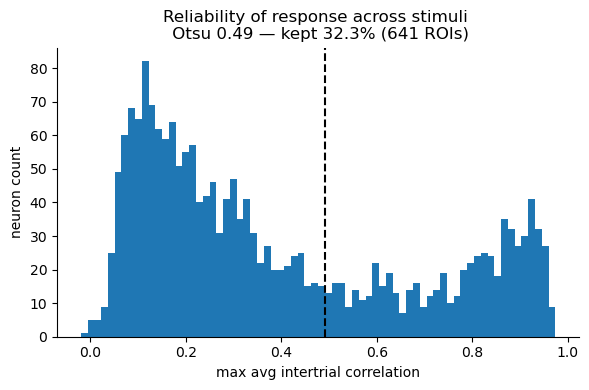

In [126]:
# plot a histograme of the correlation between neuron activity and stimuli
hist_bins = 70
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(nanfiltered_max_stimuli_correlation, bins=hist_bins)
kept_pct = (100.0 * kept_neuron_indices.size / n_neurons) if n_neurons else 0.0
ax.axvline(otsu_threshold, linestyle="--", color="k")
ax.set(title=f"Reliability of response across stimuli \n Otsu {otsu_threshold:.2f} — kept {kept_pct:.1f}% ({kept_neuron_indices.size} ROIs)",
       xlabel="max avg intertrial correlation", ylabel="neuron count")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

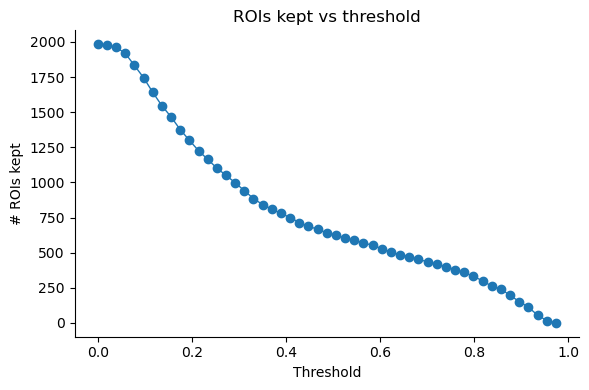

In [127]:
# plot the number of neurons accepted as a function of threshold.(again correlation)

low = max(0.0, float(np.nanmin(nanfiltered_max_stimuli_correlation)))
high = min(1.0, max(float(np.nanmax(nanfiltered_max_stimuli_correlation)), low + 1e-6))
thr_grid = np.linspace(low, high, 51)

counts = [np.sum(nanfiltered_max_stimuli_correlation >= thr) for thr in thr_grid]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(thr_grid, counts, marker="o", linewidth=1)
ax.set(title="ROIs kept vs threshold",
       xlabel="Threshold", ylabel="# ROIs kept")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [128]:
# plot neurons that where accepted and compared with neurons that does not pass the filter

def plot_accepted_rejected_rasters(
    dfof: np.ndarray,             # (n_neurons, n_frames)
    t=None,                       # (n_frames,) OR None OR scalar dt
    kept_mask: np.ndarray=None,   # (n_neurons,), boolean
    vmax: float = None,
    vmin: float = 0.0,
    perc_for_vmax: float = 99.0,
    sort_by_peak_time: bool = False,
    share_color_scale: bool = True,
):
    assert dfof.ndim == 2, "dfof must be (n_neurons, n_frames)"
    n_neurons, n_frames = dfof.shape

    # --- Build time axis or extent ---
    if t is None:
        # no time given → use frame indices
        x0, x1 = 0.0, float(n_frames - 1)
        x_label = "Frame"
    elif np.isscalar(t):  # treat as dt (sampling interval)
        dt = float(t)
        x0, x1 = 0.0, dt * (n_frames - 1)
        x_label = "Time (s)"
    else:
        t = np.asarray(t)
        assert t.ndim == 1 and t.size == n_frames, "t must be 1-D with length n_frames"
        x0, x1 = float(t[0]), float(t[-1])
        x_label = "Time"

    if kept_mask is None:
        kept_mask = np.ones(n_neurons, dtype=bool)
    else:
        kept_mask = np.asarray(kept_mask, dtype=bool)
        assert kept_mask.shape[0] == n_neurons, "kept_mask length must match n_neurons"

    kept_idx = np.flatnonzero(kept_mask)
    rej_idx  = np.setdiff1d(np.arange(n_neurons), kept_idx)

    # --- Color scaling ---
    if vmax is None:
        finite_vals = dfof[np.isfinite(dfof)]
        vmax = np.percentile(finite_vals, perc_for_vmax) if finite_vals.size else 1.0
        if not np.isfinite(vmax) or vmax <= 0:
            vmax = np.nanmax(dfof) if np.isfinite(np.nanmax(dfof)) else 1.0

    vmax_kept = vmax
    vmax_rej  = vmax
    if not share_color_scale:
        if kept_idx.size:
            tmp = np.percentile(dfof[kept_idx], perc_for_vmax)
            vmax_kept = tmp if np.isfinite(tmp) and tmp > 0 else vmax
        if rej_idx.size:
            tmp = np.percentile(dfof[rej_idx], perc_for_vmax)
            vmax_rej  = tmp if np.isfinite(tmp) and tmp > 0 else vmax

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

    def mat_for(idx):
        M = dfof[idx] if idx.size else np.zeros((1, n_frames))
        if sort_by_peak_time and idx.size > 1:
            order = np.argsort(np.argmax(M, axis=1))
            M = M[order]
        return M

    for (title, idx, vmax_here, ax) in [
        ("Accepted", kept_idx, vmax_kept, axes[0]),
        ("Rejected", rej_idx,  vmax_rej,  axes[1]),
    ]:
        M = mat_for(idx)
        im = ax.imshow(
            M,
            aspect='auto',
            interpolation='nearest',
            origin='lower',
            extent=[x0, x1, 0, M.shape[0]],
            vmin=vmin,
            vmax=vmax_here,
            cmap='gray_r',       # high = dark
        )
        ax.set_title(f"{title} (n={idx.size})")
        ax.set_xlabel(x_label)
        ax.set_ylabel("Neuron #")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("ΔF/F")

    if share_color_scale:
        fig.suptitle(f"ΔF/F rasters (shared vmin={vmin:.3g}, vmax={vmax:.3g})", y=1.02)
    else:
        fig.suptitle(
            f"ΔF/F rasters (vmin={vmin:.3g}, kept vmax={vmax_kept:.3g}, rejected vmax={vmax_rej:.3g})",
            y=1.02
        )
    return fig, axes


(3340, 641)


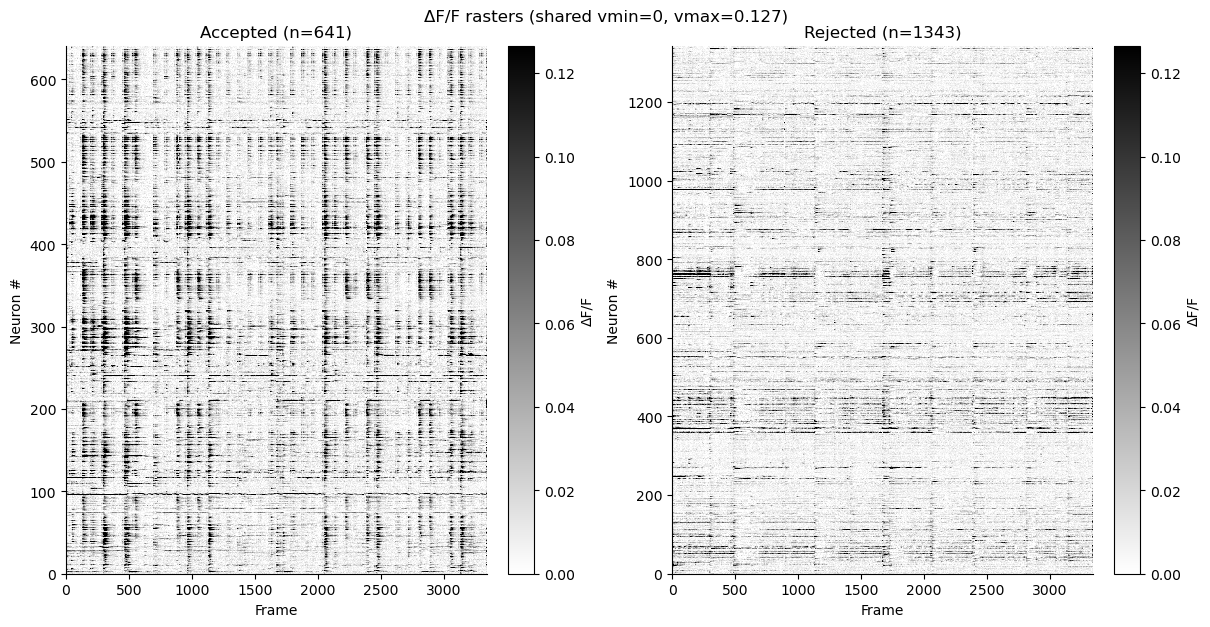

In [129]:
# Assuming you already have:
# dfof: (n_neurons, n_frames) ΔF/F
# time_2p: (n_frames,) time vector
# kept_mask: boolean (n_neurons,) from your Otsu thresholding
traces=dfof.T  # shape (n_neurons, T)
plot_accepted_rejected_rasters(traces, kept_mask=kept_mask)

print(deltaF_F.shape)

In [14]:

# average the  activity of neurons in repetition per stimuli

dt = 1.0 / float(fps_2p) #time per frame (the sampling interval) in seconds

# Containers (per stimulus → arrays of shape (n_kept,))
mean_traces = {}   # trial-averaged timecourses (kept neurons)
peaks = {}
aucs  = {}
averages = {}

for stim in stimuli_ids:
    X = trial_aligned_traces[stim]                      # (n_neurons, win_lenght, n_trials)
    Xkept = X[kept_neuron_indices, :, :]                   # filter kept neurons
    mean_trace = np.nanmean(Xkept, axis=2)                # (kept_neurons, win_lenght)
    mean_traces[stim] = mean_trace

    # Stimulus window (without pre stim frames)
    Y = mean_trace[:, pre_frames:win_lenght]                # (n_kept, n_post)
    peaks[stim] = np.nanmax(Y, axis=1) # peak ΔF/F
    aucs[stim]  = np.trapezoid(np.nan_to_num(Y), dx=dt, axis=1)  # AUC (ΔF/F * s), NaNs→0
    averages[stim] = np.nanmean(Y, axis=1)

In [15]:
 #select colors and linestyles for stimuli
# --- Set A (default) ----------------------------------------------------------
colors_A = {
    'LLB': sns.color_palette('Blues', 8)[7],
    'RLB': sns.color_palette('Greens', as_cmap=True)(0.6),
    'FLB': sns.color_palette('Blues', 8)[7],
    'FRB': sns.color_palette('Greens', as_cmap=True)(0.6),
    'FL1': sns.color_palette('PuRd', as_cmap=True)(0.9),
    'FL2': sns.color_palette('PuRd', as_cmap=True)(0.6),
    'FL3': sns.color_palette('dark:#404040', 10)[7],
    'FR1': sns.color_palette('PuRd', as_cmap=True)(0.9),
    'FR2': sns.color_palette('PuRd', as_cmap=True)(0.6),
    'FR3': sns.color_palette('dark:#404040', 10)[7],
}
linestyles_A = {
    'FLB': '--',
    'FRB': '--',
    'FL1': '--',
    'FL2': '--',
    'FL3': '--',
}

# --- Set B (rocking experiment) ----------------------------------------------
colors_B = {
    'LB':   sns.color_palette('Blues', 8)[7],
    'RR1':  sns.color_palette('Greens', as_cmap=True)(0.6),
    'RB':   sns.color_palette('Blues', 8)[7],
    'RL1':  sns.color_palette('Greens', as_cmap=True)(0.6),
    'RR2':  sns.color_palette('PuRd', as_cmap=True)(0.9),
    'RR3':  sns.color_palette('PuRd', as_cmap=True)(0.6),
    'RLR1': sns.color_palette('dark:#404040', 10)[7],
    'RL2':  sns.color_palette('PuRd', as_cmap=True)(0.9),   # fixed case from 'Rl2' → 'RL2'
    'RL3':  sns.color_palette('PuRd', as_cmap=True)(0.6),
    'RLR2': sns.color_palette('dark:#404040', 10)[7],
}
linestyles_B = {
    'LB': '--',
    'RL1': '--',
    'RL2': '--',
    'RL3': '--',
    'RLR2': '--',
}

# --- Select set based on experiment name --------------------------------------
if experiment_name == 'Exp_2_rocking_1':
    stimuli_colors = colors_B
    stimuli_linestyles = linestyles_B
else:
    stimuli_colors = colors_A
    stimuli_linestyles = linestyles_A

print("Using colors for:", experiment_name)
print(stimuli_linestyles)

Using colors for: Exp_1_flickering
{'FLB': '--', 'FRB': '--', 'FL1': '--', 'FL2': '--', 'FL3': '--'}


In [132]:
# this function plot Df/F as a function of time per stimuli...

def plot_stimulus_means(
    mean_traces,
    stimuli_ids,
    stimuli_names,                 # list of display names (used to look up styles)
    kept_neuron_indices,
    fps_2p,
    win_lenght,
    pre_frames,
    guide_times=(0.0, 8.0, 18.4),
    title_prefix="neurons resposive to stimuli",
    show_sem=True,
    # NEW: pass styles in
    stimuli_colors: dict | None = None,     # e.g., {"LLB": (r,g,b), "FLB": ...}
    stimuli_linestyles: dict | None = None, # e.g., {"FLB": "--", "FRB": "--"}
    # saving controls
    save: bool = False,
    plots_path: Path | str | None = None,
    prefix: str | None = None,
    dpi: int = 600,
    close_after: bool = False,
    comment="all_stimuli" # for saving
):
    """
    Plots mean ± SEM per stimulus.
    Styles are looked up by stimulus *name* in `stimuli_colors` and `stimuli_linestyles`.
    """
    # defaults if not provided
    if stimuli_colors is None:     stimuli_colors = {}
    if stimuli_linestyles is None: stimuli_linestyles = {}

    # time axis (s), 0 at static onset
    t = (np.arange(win_lenght) - pre_frames) / float(fps_2p)
    n_sel = int(kept_neuron_indices.size)

    fig, ax = plt.subplots(figsize=(7, 4.5))
    color_by_stim = {}

    # optional warnings for missing styles
    missing_colors = [nm for nm in stimuli_names if nm not in stimuli_colors]
    missing_ls     = [nm for nm in stimuli_names if nm not in stimuli_linestyles]
    if missing_colors:
        print("[warn] No color for:", missing_colors, "→ using Matplotlib defaults.")
    if missing_ls:
        print("[warn] No linestyle for:", missing_ls, "→ using solid '-'.")

    for i, stim in enumerate(stimuli_ids):
        name = stimuli_names[i]                 # look up styles by NAME
        M = mean_traces[stim]                   # (n_kept, win_lenght)
        trace_mean = np.nanmean(M, axis=0)
        trace_sd   = np.nanstd(M,  axis=0)
        trace_sem  = trace_sd / np.sqrt(max(n_sel, 1))

        color = stimuli_colors.get(name, None)        # None → mpl default
        ls    = stimuli_linestyles.get(name, "-")     # default solid

        (line,) = ax.plot(t, trace_mean, label=name, color=color, linestyle=ls)
        color_by_stim[name] = line.get_color()

        if show_sem:
            ax.fill_between(
                t, trace_mean - trace_sem, trace_mean + trace_sem,
                alpha=0.18, color=line.get_color(), linewidth=0
            )

    # visual guides
    static_onset, motion_onset, motion_offset = guide_times
    ax.axvline(static_onset, linestyle="--", linewidth=1, color="grey", label="static onset")
    ax.text(static_onset - 0.5, 0.85, "static", rotation=90, va="bottom", ha="center",
            transform=ax.get_xaxis_transform())
    ax.axvline(motion_onset, linewidth=1, color="k", label="motion onset")
    ax.text(motion_onset + 1.5, 0.85, "motion", rotation=90, va="bottom", ha="center",
            transform=ax.get_xaxis_transform())
    ax.axvline(motion_offset, linestyle="--", linewidth=1, color="grey")

    # cosmetics
    ax.set(title=f"{title_prefix}\n(n={n_sel})",
           xlabel="Time (s) relative to onset",
           ylabel="ΔF/F")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    plt.subplots_adjust(right=0.78)
    plt.tight_layout()

    out_png = None
    if save:
        if plots_path is None or prefix is None:
            print("⚠️  Save was requested but `plots_path` or `prefix` is missing—skipping save.")
        else:
            plots_path = Path(plots_path)
            plots_path.mkdir(parents=True, exist_ok=True)
            out_png = plots_path / f"{prefix}_dfof_as_func_of_time_{comment}.png"
            fig.savefig(out_png, dpi=dpi, bbox_inches="tight")
            print("✅ Saved:", out_png)

    if close_after:
        plt.close(fig)
    else:
        plt.show()

    return fig, ax, color_by_stim, out_png


[warn] No linestyle for: ['FR1', 'FR2', 'FR3', 'LLB', 'RLB'] → using solid '-'.
✅ Saved: C:\Users\suribear\OneDrive - Université de Lausanne\Lab\Data\2p\L433_f02_Exp_1_flickering\03_analysis\functional\plots\stimuli_selected_dFoF\L433_f02_dfof_as_func_of_time_all_stimuli.png


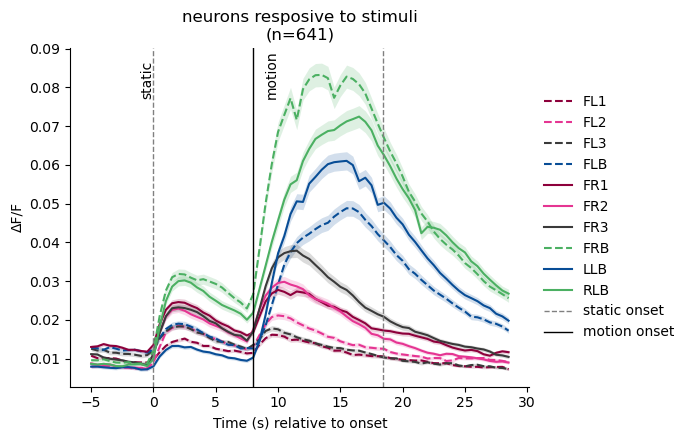

In [133]:
fig, ax, used_colors, out_path = plot_stimulus_means(
    mean_traces=mean_traces,
    stimuli_ids=stimuli_ids,
    stimuli_names=stimuli_names,
    kept_neuron_indices=kept_neuron_indices,
    fps_2p=fps_2p,
    win_lenght=win_lenght,
    pre_frames=pre_frames,
    guide_times=(0.0, 8.0, 18.4),
    plots_path=plots_path,       # Path object or str
    prefix=prefix,               # e.g., "exp12_mouseA"
    dpi=600,
    save=True,
    stimuli_colors=stimuli_colors,            # <— pass styles here
    stimuli_linestyles=stimuli_linestyles,
    close_after=False,
    comment="all_stimuli" # for saving
)


In [115]:
# Map ID -> name (from your parallel lists)
id2name = {sid: stimuli_names[i] for i, sid in enumerate(stimuli_ids)}

# Define merged groups by ID
# keep the FIRST ID of each group as the new key
groups = {
    1: [1, 2],
    2: [3, 8],
    3: [4,9],
    4: [5,10],
    5: [6],
    6: [7]
}

dt = 1.0 / float(fps_2p)

mean_traces = {}
peaks = {}
aucs  = {}
averages = {}

for new_id, member_ids in groups.items():
    # X = concat trials from all member stimuli along axis=2
    X = np.concatenate([trial_aligned_traces[sid] for sid in member_ids], axis=2)
    print(X.shape)
    Xkept = X[kept_neuron_indices, :, :]
    mean_trace = np.nanmean(Xkept, axis=2)              # (n_kept, win_lenght)
    mean_traces[new_id] = mean_trace

    Y = mean_trace[:, pre_frames:win_lenght]
    peaks[new_id]    = np.nanmax(Y, axis=1)
    aucs[new_id]     = np.trapezoid(np.nan_to_num(Y), dx=dt, axis=1)
    averages[new_id] = np.nanmean(Y, axis=1)

# Update the lists you use for plotting (IDs stay IDs; names by id2name)
stimuli_ids   = list(groups.keys())                     # [1, 3, 6, 7, 8]
stimuli_names = ['Bouts', 'R_1', 'R_2', 'R_3', 'RBS_1', 'RBS_2']

# stimuli_colors
colors_C = {
    'Bouts': sns.color_palette('Greens', as_cmap=True)(0.6),
    'R_1':  sns.color_palette('Greens', as_cmap=True)(0.6),
    'R_2':  sns.color_palette('Blues', 8)[7],
    'R_3':   sns.color_palette('dark:#404040', 10)[7],
    'RBS_1': sns.color_palette('PuRd', as_cmap=True)(0.9),
    'RBS_2': sns.color_palette('PuRd', as_cmap=True)(0.6),
}
linestyles_C = {
    'R_1': '--',
    'RBS_2': '--',
    }

fig, ax, used_colors, out_path = plot_stimulus_means(
    mean_traces=mean_traces,
    stimuli_ids=stimuli_ids,
    stimuli_names=stimuli_names,
    kept_neuron_indices=kept_neuron_indices,
    fps_2p=fps_2p,
    win_lenght=win_lenght,
    pre_frames=pre_frames,
    guide_times=(0.0, 8.0, 18.4),
    plots_path=plots_path,       # Path object or str
    prefix=prefix,               # e.g., "exp12_mouseA"
    dpi=600,
    save=False,
    stimuli_colors=colors_C,            # <— pass styles here
    stimuli_linestyles=linestyles_C,
    close_after=False,
    comment="merge_stimuli" # for saving
)

(1984, 68, 8)


KeyError: 8

In [107]:
print(stimuli_names)

['FL1', 'FL2', 'FL3', 'FLB', 'FR1', 'FR2', 'FR3', 'FRB', 'LLB', 'RLB']


(1984, 68, 8)
(1984, 68, 8)
(1984, 68, 8)
(1984, 68, 8)
(1984, 68, 8)
[warn] No linestyle for: ['Bouts', 'F_1', 'F_2', 'F_3'] → using solid '-'.


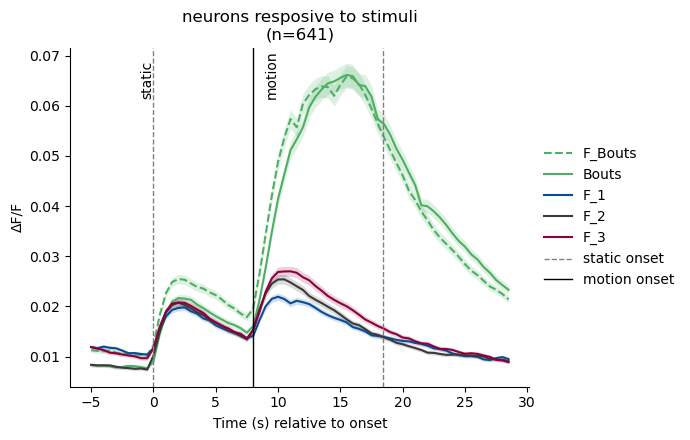

In [134]:
# Map ID -> name (from your parallel lists)
id2name = {sid: stimuli_names[i] for i, sid in enumerate(stimuli_ids)}

# Define merged groups by ID
# keep the FIRST ID of each group as the new key
groups = {
    1: [4, 8],
    2: [9, 10],
    3: [1,5],
    4: [2,6],
    5: [3,7],
}

dt = 1.0 / float(fps_2p)

mean_traces = {}
peaks = {}
aucs  = {}
averages = {}

for new_id, member_ids in groups.items():
    # X = concat trials from all member stimuli along axis=2
    X = np.concatenate([trial_aligned_traces[sid] for sid in member_ids], axis=2)
    print(X.shape)
    Xkept = X[kept_neuron_indices, :, :]
    mean_trace = np.nanmean(Xkept, axis=2)              # (n_kept, win_lenght)
    mean_traces[new_id] = mean_trace

    Y = mean_trace[:, pre_frames:win_lenght]
    peaks[new_id]    = np.nanmax(Y, axis=1)
    aucs[new_id]     = np.trapezoid(np.nan_to_num(Y), dx=dt, axis=1)
    averages[new_id] = np.nanmean(Y, axis=1)

# Update the lists you use for plotting (IDs stay IDs; names by id2name)
stimuli_ids   = list(groups.keys())                     # [1, 3, 6, 7, 8]
stimuli_names = ['F_Bouts', 'Bouts', 'F_1', 'F_2', 'F_3']

# stimuli_colors
colors_C = {
    'F_Bouts': sns.color_palette('Greens', as_cmap=True)(0.6),
    'Bouts':  sns.color_palette('Greens', as_cmap=True)(0.6),
    'F_1':  sns.color_palette('Blues', 8)[7],
    'F_2':   sns.color_palette('dark:#404040', 10)[7],
    'F_3': sns.color_palette('PuRd', as_cmap=True)(0.9),

}
linestyles_C = {
    'F_Bouts': '--',
    }

fig, ax, used_colors, out_path = plot_stimulus_means(
    mean_traces=mean_traces,
    stimuli_ids=stimuli_ids,
    stimuli_names=stimuli_names,
    kept_neuron_indices=kept_neuron_indices,
    fps_2p=fps_2p,
    win_lenght=win_lenght,
    pre_frames=pre_frames,
    guide_times=(0.0, 8.0, 18.4),
    plots_path=plots_path,       # Path object or str
    prefix=prefix,               # e.g., "exp12_mouseA"
    dpi=600,
    save=False,
    stimuli_colors=colors_C,            # <— pass styles here
    stimuli_linestyles=linestyles_C,
    close_after=False,
    comment="merge_stimuli"
)

In [19]:
# assume fps_stim is defined (e.g., 60) and ax is your matplotlib axes
fps_stim=FPS_stimuli
deltaF_F=dfof[:,kept_mask]
exp_log= adjusted_log
for stim_name, timing in stimuli_durations.items():
    start_f = timing.get('start_frame', timing.get('motion_start_frame'))
    end_f   = timing.get('end_frame',   timing.get('motion_end_frame'))
    if start_f is None or end_f is None:
        print(f"Skipping {stim_name}: no start/end frame keys")
        continue

    start = start_f / fps_stim
    end   = end_f   / fps_stim
    ax.axvspan(start, end, alpha=0.3)  # avoid hardcoding a color unless you want to


NameError: name 'ax' is not defined

Plotting

In [37]:
# select parameters including sorting mode, stimuli order, and windows
# sort deltaF_F base on max_intensity, correlation, kmeans, "pca", "hier",  or "unsorted"
# --- choose stimulus-aligned windows ---
from scipy.cluster.hierarchy import linkage, fcluster, leaves_list
# --- choose neuron sorting ---
window_pre = 5  # seconds before stimulus
window_post = 17  # seconds after stimulus


# <-- change to: max_intensity, correlation, kmeans, "pca", "hier",  or "unsorted"
sort_mode = "max_intensity"

# define stimuli order based on experiment
stimuli_ordered_A = ['LLB', 'FLB', 'RLB' , 'FRB','FL1', 'FL2', 'FL3', 'FR1', 'FR2', 'FR3']  # Order of
stimuli_ordered_B = ['LB','RB','RR1','RR2','RR3','RL1','RL2','RL3','RLR1','RLR2' ]

if experiment_name == 'Exp_2_rocking_1':
    stimuli_ordered = stimuli_ordered_B
else:
    stimuli_ordered = stimuli_ordered_A

# (a) Max intensity (peak ΔF/F per neuron)
max_per_neuron   = np.nanmax(deltaF_F, axis=0)         # (neurons,)
maxint_sorted_idx = np.argsort(-max_per_neuron)

# (b) PCA (PC1 desc) over neurons
scores    = PCA(n_components=3).fit_transform(deltaF_F.T )  # (neurons, 3)
PCA_order = np.argsort(-scores[:, 0])

# (c) KMeans over neurons
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(deltaF_F.T )
kmeans_sorted_idx = np.argsort(kmeans.labels_)  # group by label

# (d) Hierarchical (Ward) over neurons
Z_hier = linkage(deltaF_F.T , method='ward')
clusters = fcluster(Z_hier, t=5, criterion='maxclust')
hier_sorted_idx = np.argsort(clusters)

# (e) Correlation sort on the **averaged chunks** (neurons x time)
dist = pdist(deltaF_F.T, metric='correlation')
Z_corr = linkage(dist, method='average')
corravg_sorted_idx = leaves_list(Z_corr)


n_neurons = deltaF_F.shape[1]

def _validate_order(idx, name):
    if idx is None:
        raise ValueError(f"{name} is not defined but sort_mode='{name}' was selected.")
    if len(idx) != n_neurons:
        raise ValueError(f"{name} length ({len(idx)}) != number of neurons ({n_neurons}).")
    return idx

if sort_mode == "kmeans":
    neuron_order = _validate_order(kmeans_sorted_idx, "kmeans_sorted_idx")
elif sort_mode == "pca":
    neuron_order = _validate_order(PCA_order, "PCA_order")
elif sort_mode == "hier":
    neuron_order = _validate_order(hier_sorted_idx, "hier_sorted_idx")
elif sort_mode == "max_intensity":
    neuron_order = _validate_order(maxint_sorted_idx, "maxint_sorted_idx")
elif sort_mode == "correlation":
    neuron_order = _validate_order(corravg_sorted_idx, "corravg_sorted_idx")
elif sort_mode == "unsorted":
    neuron_order = None
else:
    raise ValueError("sort_mode must be one of: 'kmeans', 'pca', 'hier', 'max_intensity', 'unsorted'")
print(stimuli_ordered)

C:\Users\suribear\AppData\Local\anaconda3\envs\neuro-group\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


['LLB', 'FLB', 'RLB', 'FRB', 'FL1', 'FL2', 'FL3', 'FR1', 'FR2', 'FR3']


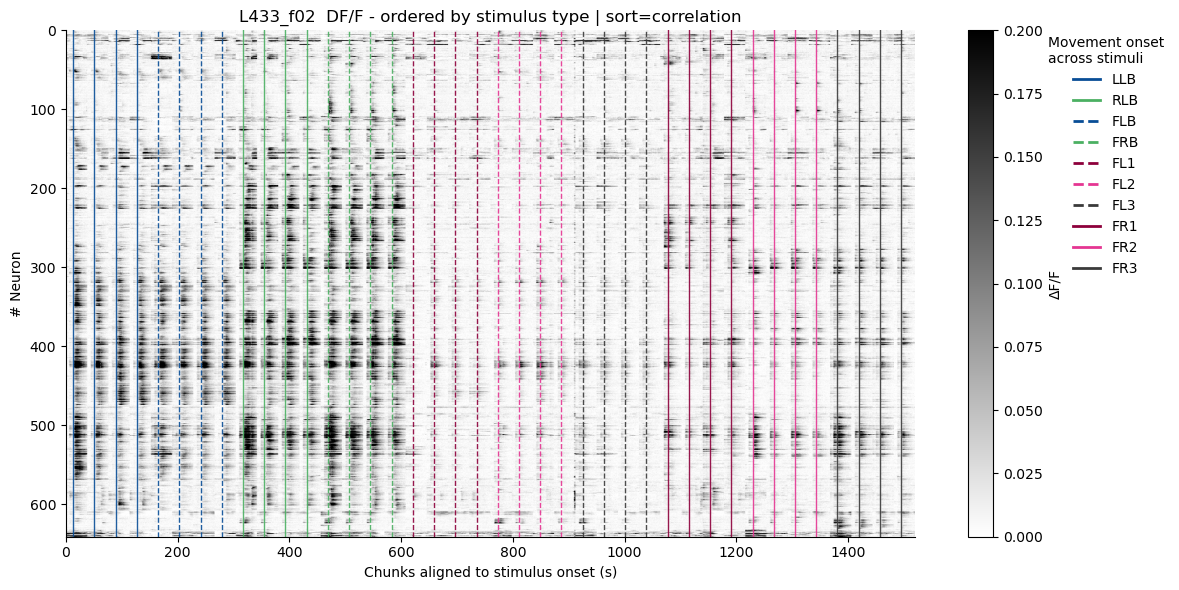

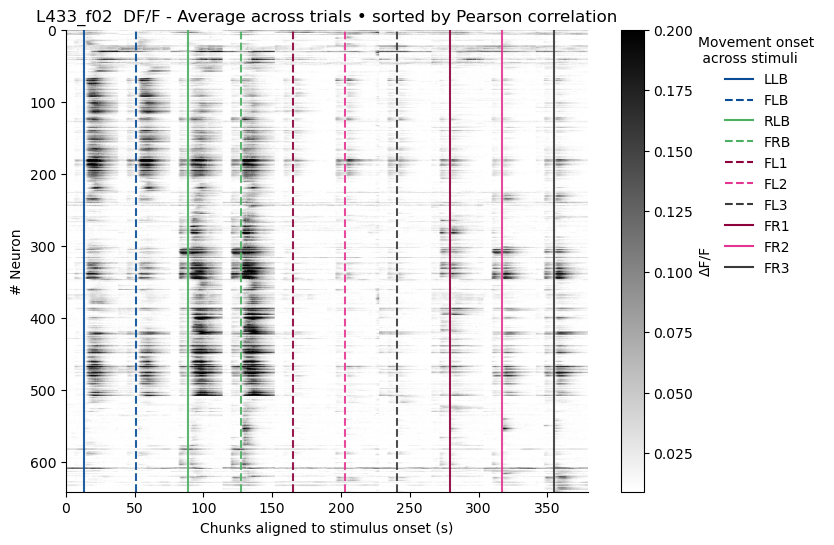

In [21]:
# gruped chunks ordered by stimulus type, sorted by selected method

# 1) Build chunks
chunked_data, trial_starts, move_starts, move_colors, stim_labels = st.extract_stimulus_chunks(
    deltaF_F=deltaF_F,
    exp_log=exp_log,
    stimuli_durations=stimuli_durations,
    stimuli_colors=stimuli_colors,
    fps=fps_2p,
    stimuli_ordered=stimuli_ordered,
    window_pre=window_pre,
    window_post=window_post,
    average_across_repeats=False,
)

if chunked_data is None or chunked_data.size == 0:
    raise ValueError("No stimulus chunks were extracted. Check exp_log, stimuli_ordered, and windows.")

# 2) Plot raster
fig, ax = plt.subplots(figsize=(12, 6))
im = plott.raster_with_stimuli(
    ax=ax,
    deltaF_F=chunked_data.T,   # (time, neurons)
    fps=fps_2p,
    fish_id=fish_id,
    neuron_order=neuron_order, # provided by your sort selector
    title_suffix=f"ordered by stimulus type | sort={sort_mode}",
    max=0.2
)

# 3) Movement start lines — use style based on each chunk's stimulus label
move_styles = [stimuli_linestyles.get(name, '-') for name in stim_labels]
for pos, color, ls in zip(move_starts, move_colors, move_styles):
    ax.axvline(pos / fps_2p, color=color, linestyle=ls, alpha=0.9, linewidth=1.0)

ax.set_xlabel("Chunks aligned to stimulus onset (s)")

# 4) Legend that matches color + linestyle
legend_handles = []
for stim_name, color in stimuli_colors.items():
    ls = stimuli_linestyles.get(stim_name, '-')
    (line,) = ax.plot([], [], color=color, linestyle=ls, label=stim_name, linewidth=2)
    legend_handles.append(line)

ax.legend(
    handles=legend_handles,
    title="Movement onset\nacross stimuli",
    bbox_to_anchor=(1.15, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

# 5) Colorbar + layout
fig.colorbar(im, ax=ax, label="ΔF/F")
fig.tight_layout()
plt.show()

############################ AVERAGE

# averaged chunked_data shape: (neurons, time) sorted by stimulus type and by pearson correlation
# ---- 1) Extract chunks from the full dfof, averaged across repeats ----
chunked_data, trial_starts, move_starts, move_colors, stim_labels = st.extract_stimulus_chunks(
    deltaF_F=deltaF_F,                 # (frames, neurons)
    exp_log=exp_log,
    stimuli_durations=stimuli_durations,
    stimuli_colors=stimuli_colors,
    fps=fps_2p,
    stimuli_ordered=stimuli_ordered,
    window_pre=window_pre,
    window_post=window_post,
    average_across_repeats=True
)

if chunked_data is None or chunked_data.size == 0:
    raise ValueError("No stimulus chunks were extracted. Check exp_log, stimuli_ordered, and windows.")

# chunked_data shape: (neurons, time)  ✅

# ---- 2) Compute distances: 1 - Pearson correlation across the (averaged) chunked time series ----
dist = pdist(chunked_data, metric='correlation')  # rows = neurons, columns = time (averaged)
Z = linkage(dist, method='average')
sorted_indices = leaves_list(Z)

# ---- 3) Plot the correlation-sorted raster ----
fig, ax = plt.subplots(figsize=(9, 6))
im = plott.raster_with_stimuli(
    ax=ax,
    deltaF_F=chunked_data.T,    # (time, neurons)
    fps=fps_2p,
    fish_id=fish_id,
    neuron_order=sorted_indices,
    title_suffix='Average across trials • sorted by Pearson correlation',
    min=0.009,
    max=0.2
)


# 3) ➜ Overlay movement start lines using per-stim linestyle
for pos, stim_name in zip(move_starts, stim_labels):
    color = stimuli_colors.get(stim_name, 'black')
    ls    = stimuli_linestyles.get(stim_name, '-')   # default solid if not specified
    ax.axvline(pos / fps_2p, color=color, linestyle=ls, alpha=0.9, linewidth=1.5)

# 4) ➜ Legend that reflects both color and linestyle
legend_handles = []
for stim_name in stimuli_ordered:
    if stim_name in stimuli_colors:
        color = stimuli_colors[stim_name]
        ls    = stimuli_linestyles.get(stim_name, '-')  # same default
        (line,) = ax.plot([], [], color=color, linestyle=ls, label=stim_name, linewidth=1.5)
        legend_handles.append(line)

ax.legend(
    handles=legend_handles,
    title="Movement onset \n across stimuli",
    bbox_to_anchor=(1.2, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False
)

ax.set_xlabel("Chunks aligned to stimulus onset (s)")

# 5) Colorbar + layout ... [unchanged]
fig.colorbar(im, ax=ax, label="ΔF/F")
plt.subplots_adjust(right=0.85)
plt.show()


C:\Users\suribear\AppData\Local\anaconda3\envs\neuro-group\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(

KeyboardInterrupt


KeyboardInterrupt



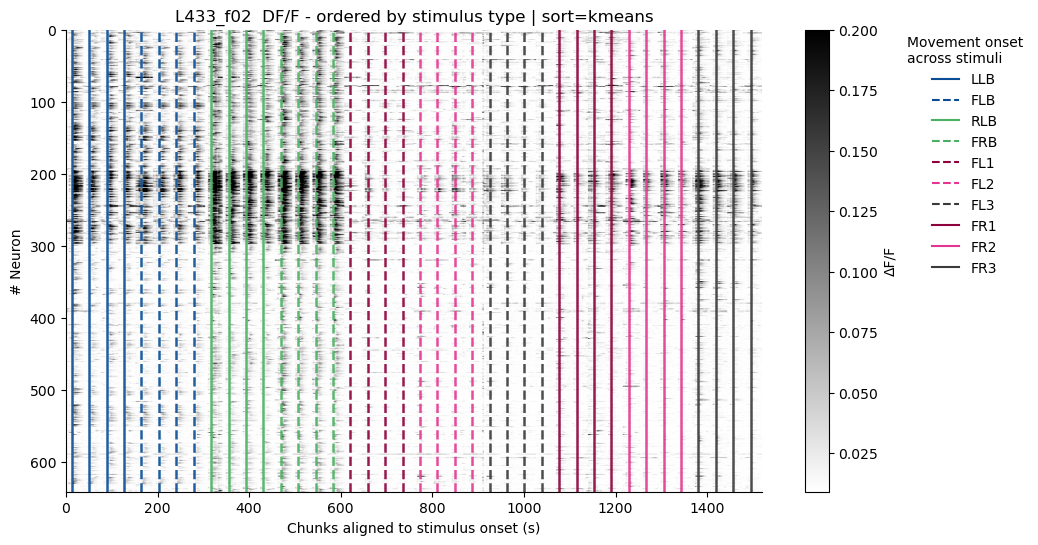

In [21]:
## saved plot of gruped chunks ordered by stimulus type, sorted by selected method

import os
os.environ["OMP_NUM_THREADS"] = "2"  # or "1"

# ----- pick a short prefix like "L433_f03" from "L433_f03_Exp_1_flickering"
prefix = "_".join(fish.split("_")[:2])

# ----- ensure output dir exists
plots_path.mkdir(parents=True, exist_ok=True)

# ===== 1) Build chunks (averaged across repeats) once =====
chunked_data, trial_starts, move_starts, move_colors, stim_labels = st.extract_stimulus_chunks(
    deltaF_F=deltaF_F,                 # (frames, neurons)
    exp_log=exp_log,
    stimuli_durations=stimuli_durations,
    stimuli_colors=stimuli_colors,
    fps=fps_2p,
    stimuli_ordered=stimuli_ordered,
    window_pre=window_pre,
    window_post=window_post,
    average_across_repeats=False
)
if chunked_data is None or chunked_data.size == 0:
    raise ValueError("No stimulus chunks were extracted. Check exp_log, stimuli_ordered, and windows.")
# chunked_data: (neurons, time)

# ===== 2) Precompute neuron orders for each sort mode (on full dfof unless noted) =====
#deltaF_F = dfof  # (frames, neurons)

# (a) Max intensity (peak ΔF/F per neuron)
max_per_neuron   = np.nanmax(chunked_data.T, axis=0)         # (neurons,)
maxint_sorted_idx = np.argsort(-max_per_neuron)

# (b) PCA (PC1 desc) over neurons
scores    = PCA(n_components=3).fit_transform(chunked_data)  # (neurons, 3)
PCA_order = np.argsort(-scores[:, 0])

# (c) KMeans over neurons
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(chunked_data)
kmeans_sorted_idx = np.argsort(kmeans.labels_)  # group by label

# (d) Hierarchical (Ward) over neurons
Z_hier = linkage(chunked_data, method='ward')
clusters = fcluster(Z_hier, t=5, criterion='maxclust')
hier_sorted_idx = np.argsort(clusters)

# (e) Correlation sort on the **averaged chunks** (neurons x time)
dist = pdist(chunked_data, metric='correlation')
Z_corr = linkage(dist, method='average')
corravg_sorted_idx = leaves_list(Z_corr)

# Map from mode -> (index array or None, label suffix)
sorters = {
    "unsorted":        (None,                   "unsorted"),
    "max_intensity":   (maxint_sorted_idx,      "max_intensity"),
    "pca":             (PCA_order,              "pca"),
    "kmeans":          (kmeans_sorted_idx,      "kmeans"),
    "hier":            (hier_sorted_idx,        "hier"),
    "corravg":         (corravg_sorted_idx,     "corravg"),  # correlation on averaged chunks
}


def _validate_order(idx, n_neurons, name):
    if idx is None:
        return None
    if len(idx) != n_neurons:
        raise ValueError(f"{name} length ({len(idx)}) != number of neurons ({n_neurons}).")
    return idx

# ===== 3) Plot once per sort mode (use chunked_data for raster) =====
for mode, (idx, tag) in sorters.items():
    neuron_order = _validate_order(idx, chunked_data.shape[0], name=mode)

    fig, ax = plt.subplots(figsize=(12, 6))
    im = plott.raster_with_stimuli(
        ax=ax,
        deltaF_F=chunked_data.T,            # (time, neurons)
        fps=fps_2p,
        fish_id=fish_id,
        neuron_order=neuron_order,          # None = original order
        title_suffix=f"ordered by stimulus type | sort={tag}",
        min=0.009,
        max=0.2
    )

    # Movement onset lines with per-stim color + linestyle
    for pos, stim_name in zip(move_starts, stim_labels):
        color = stimuli_colors.get(stim_name, 'black')
        ls    = stimuli_linestyles.get(stim_name, '-')  # default solid
        ax.axvline(pos / fps_2p, color=color, linestyle=ls, alpha=0.9, linewidth=1.8)

    # Legend (color + linestyle)
    legend_handles = []
    for stim_name in stimuli_ordered:
        if stim_name in stimuli_colors:
            color = stimuli_colors[stim_name]
            ls    = stimuli_linestyles.get(stim_name, '-')
            (line,) = ax.plot([], [], color=color, linestyle=ls, label=stim_name, linewidth=1.5)
            legend_handles.append(line)

    leg = ax.legend(
        handles=legend_handles, title="Movement onset\nacross stimuli",
        bbox_to_anchor=(1.2, 1), loc='upper left',
        borderaxespad=0, frameon=False
    )

    ax.set_xlabel("Chunks aligned to stimulus onset (s)")
    fig.colorbar(im, ax=ax, label="ΔF/F")
    plt.subplots_adjust(right=0.85)

    # Save
    out_png = plots_path / f"{prefix}_grouped_dfof_sorted_by_{tag}.png"
    fig.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.close(fig)

print("✅ Saved:", *[f"{prefix}_grouped_dfof_sorted_by_{tag}.png" for _, (_, tag) in sorters.items()], sep="\n- ")

In [106]:
# Purpose.
# Generate experiment-level ΔF/F rasters aligned to stimulus onsets, averaged across repeats, and saved once per sorting strategy (unsorted, max intensity, PCA, KMeans, hierarchical, and correlation on averaged responses).
# save all these plots

import os

os.environ["OMP_NUM_THREADS"] = "2"  # or "1"

# ----- pick a short prefix like "L433_f03" from "L433_f03_Exp_1_flickering"
prefix = "_".join(fish.split("_")[:2])

# ----- ensure output dir exists
plots_path.mkdir(parents=True, exist_ok=True)

# ===== 1) Build chunks (averaged across repeats) once =====
chunked_data, trial_starts, move_starts, move_colors, stim_labels = st.extract_stimulus_chunks(
    deltaF_F=deltaF_F,  # (frames, neurons)
    exp_log=exp_log,
    stimuli_durations=stimuli_durations,
    stimuli_colors=stimuli_colors,
    fps=fps_2p,
    stimuli_ordered=stimuli_ordered,
    window_pre=window_pre,
    window_post=window_post,
    average_across_repeats=True
)
if chunked_data is None or chunked_data.size == 0:
    raise ValueError("No stimulus chunks were extracted. Check exp_log, stimuli_ordered, and windows.")
# chunked_data: (neurons, time)

# ===== 2) Precompute neuron orders for each sort mode (on full dfof unless noted) =====
# deltaF_F = dfof  # (frames, neurons)

# (a) Max intensity (peak ΔF/F per neuron)
max_per_neuron = np.nanmax(chunked_data.T, axis=0)  # (neurons,)
maxint_sorted_idx = np.argsort(-max_per_neuron)

# (b) PCA (PC1 desc) over neurons
scores = PCA(n_components=3).fit_transform(chunked_data)  # (neurons, 3)
PCA_order = np.argsort(-scores[:, 0])

# (c) KMeans over neurons
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(chunked_data)
kmeans_sorted_idx = np.argsort(kmeans.labels_)  # group by label

# (d) Hierarchical (Ward) over neurons
Z_hier = linkage(chunked_data, method='ward')
clusters = fcluster(Z_hier, t=5, criterion='maxclust')
hier_sorted_idx = np.argsort(clusters)

# (e) Correlation sort on the **averaged chunks** (neurons x time)
dist = pdist(chunked_data, metric='correlation')
Z_corr = linkage(dist, method='average')
corravg_sorted_idx = leaves_list(Z_corr)

# Map from mode -> (index array or None, label suffix)
sorters = {
    "unsorted": (None, "unsorted"),
    "max_intensity": (maxint_sorted_idx, "max_intensity"),
    "pca": (PCA_order, "pca"),
    "kmeans": (kmeans_sorted_idx, "kmeans"),
    "hier": (hier_sorted_idx, "hier"),
    "corravg": (corravg_sorted_idx, "corravg"),  # correlation on averaged chunks
}


def _validate_order(idx, n_neurons, name):
    if idx is None:
        return None
    if len(idx) != n_neurons:
        raise ValueError(f"{name} length ({len(idx)}) != number of neurons ({n_neurons}).")
    return idx


# ===== 3) Plot once per sort mode (use chunked_data for raster) =====
for mode, (idx, tag) in sorters.items():
    neuron_order = _validate_order(idx, chunked_data.shape[0], name=mode)

    fig, ax = plt.subplots(figsize=(9, 6))
    im = plott.raster_with_stimuli(
        ax=ax,
        deltaF_F=chunked_data.T,  # (time, neurons)
        fps=fps_2p,
        fish_id=fish_id,
        neuron_order=neuron_order,  # None = original order
        title_suffix=f"average across trials | sort={tag}",
        min=0.009,
        max=0.2
    )

    # Movement onset lines with per-stim color + linestyle
    for pos, stim_name in zip(move_starts, stim_labels):
        color = stimuli_colors.get(stim_name, 'black')
        ls = stimuli_linestyles.get(stim_name, '-')  # default solid
        ax.axvline(pos / fps_2p, color=color, linestyle=ls, alpha=0.9, linewidth=1.8)

    # Legend (color + linestyle)
    legend_handles = []
    for stim_name in stimuli_ordered:
        if stim_name in stimuli_colors:
            color = stimuli_colors[stim_name]
            ls = stimuli_linestyles.get(stim_name, '-')
            (line,) = ax.plot([], [], color=color, linestyle=ls, label=stim_name, linewidth=1.5)
            legend_handles.append(line)

    leg = ax.legend(
        handles=legend_handles, title="Movement onset\nacross stimuli",
        bbox_to_anchor=(1.2, 1), loc='upper left',
        borderaxespad=0, frameon=False
    )

    ax.set_xlabel("Chunks aligned to stimulus onset (s)")
    fig.colorbar(im, ax=ax, label="ΔF/F")
    plt.subplots_adjust(right=0.85)

    # Save
    out_png = plots_path / f"{prefix}_average_dfof_sorted_by_{tag}.png"
    fig.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.close(fig)

print("✅ Saved:", *[f"{prefix}_average_dfof_sorted_by_{tag}.png" for _, (_, tag) in sorters.items()], sep="\n- ")


C:\Users\suribear\AppData\Local\anaconda3\envs\neuro-group\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✅ Saved:
- L433_f02_average_dfof_sorted_by_unsorted.png
- L433_f02_average_dfof_sorted_by_max_intensity.png
- L433_f02_average_dfof_sorted_by_pca.png
- L433_f02_average_dfof_sorted_by_kmeans.png
- L433_f02_average_dfof_sorted_by_hier.png
- L433_f02_average_dfof_sorted_by_corravg.png


In [61]:
from src.significant_traces import compute_noise_model_romano_fast_modular, plot_dff_and_raster

FPS_DEFAULT = 2.0
TAUDECAY_DEFAULT = 6.0

ST_N_BINS       = 2000
ST_K_NEIGHBORS  = 100
ST_CONF_CUTOFF  = 95
ST_PLOT_ODDS    = False
ST_VMAX_DFF     = 0.15

(mapOfOdds,
         deltaF_center,
         density_data,
         density_noise,
         xev, yev,
         raster,
         mapOfOddsJoint) = compute_noise_model_romano_fast_modular(
             deltaF_F,
             n_bins=ST_N_BINS,
             k_neighbors=ST_K_NEIGHBORS,
             confCutOff=ST_CONF_CUTOFF,
             plot_odds=ST_PLOT_ODDS,
             fps=FPS_DEFAULT,
             tauDecay=TAUDECAY_DEFAULT,
        )


[Noise Fit] Used fallback on 0 out of 641 ROIs (0.0%)


In [26]:
print(deltaF_F.shape, raster.shape)

(3340, 641) (3340, 641)


In [63]:


sort_idx = plot_dff_and_raster(deltaF_center[:,1:100], raster[:,1:100], fps=2.0, vmax_dff=0.3)

# Sanity check before pdist
n_neurons =raster.shape[1] #  frames x nueroso
nan_mask = ~np.isfinite(raster).all(axis=0)
zero_var_mask = np.nanstd(raster, axis=0) == 0

print("Neurons with any NaN:", np.where(nan_mask)[0])
print("Neurons with zero variance:", np.where(zero_var_mask)[0])
print("Total bad neurons:", np.sum(nan_mask | zero_var_mask), "out of", n_neurons)

Neurons with any NaN: []
Neurons with zero variance: [74]
Total bad neurons: 1 out of 641


In [31]:
# Sanity check before pdist
n_neurons =raster.shape[1] #  frames x nueroso
nan_mask = ~np.isfinite(raster).all(axis=0)
zero_var_mask = np.nanstd(raster, axis=0) == 0

print("Neurons with any NaN:", np.where(nan_mask)[0])
print("Neurons with zero variance:", np.where(zero_var_mask)[0])
print("Total bad neurons:", np.sum(nan_mask | zero_var_mask), "out of", n_neurons)


Neurons with any NaN: []
Neurons with zero variance: [ 74  83  87  91 112 117 122 137 154 262 272 276 278 379 383 436 465 468
 473 539 568 570 611 614]
Total bad neurons: 24 out of 641


In [ ]:
Neurons with any NaN: []
Neurons with zero variance: [ 74  83  87  91 112 117 122 137 154 262 272 276 278 379 383 436 465 468
 473 539 568 570 611 614]
Total bad neurons: 24 out of 641

Neurons with any NaN: []
Neurons with zero variance: [ 74  83  87  91 112 117 137 154 262 272 276 278 379 383 436 465 468 473
 539 568 570 611 614]
Total bad neurons: 23 out of 641


In [33]:
#raster: (frames, neurons)
n_neurons = raster.shape[1]  # frames x neurons
nan_mask = ~np.isfinite(raster).all(axis=0)         # per neuron
zero_var_mask = np.nanstd(raster, axis=0) == 0      # per neuron

print("Neurons with any NaN:", np.where(nan_mask)[0])
print("Neurons with zero variance:", np.where(zero_var_mask)[0])
print("Total bad neurons:", np.sum(nan_mask | zero_var_mask), "out of", n_neurons)

Neurons with any NaN: []
Neurons with zero variance: [ 74  83  87  91 112 117 122 137 154 262 272 276 278 379 383 436 465 468
 473 539 568 570 611 614]
Total bad neurons: 24 out of 641


In [35]:
# raster: (frames, neurons)
n_neurons = raster.shape[1]

# 1) Find bad neurons
nan_mask = ~np.isfinite(raster).all(axis=0)        # neurons with any NaN/inf
zero_var_mask = np.nanstd(raster, axis=0) == 0     # neurons with flat trace

bad_mask = nan_mask | zero_var_mask
good_mask = ~bad_mask

print("Dropped", bad_mask.sum(), "neurons out of", n_neurons)

# 2) Keep only good neurons
raster_clean = raster[:, good_mask]


import os

os.environ["OMP_NUM_THREADS"] = "2"  # or "1"

# ----- pick a short prefix like "L433_f03" from "L433_f03_Exp_1_flickering"
prefix = "_".join(fish.split("_")[:2])

# ----- ensure output dir exists
plots_path.mkdir(parents=True, exist_ok=True)

# ===== 1) Build chunks (averaged across repeats) once =====
chunked_data, trial_starts, move_starts, move_colors, stim_labels = st.extract_stimulus_chunks(
    deltaF_F=raster_clean,  # (frames, neurons)
    exp_log=exp_log,
    stimuli_durations=stimuli_durations,
    stimuli_colors=stimuli_colors,
    fps=fps_2p,
    stimuli_ordered=stimuli_ordered,
    window_pre=window_pre,
    window_post=window_post,
    average_across_repeats=True
)
if chunked_data is None or chunked_data.size == 0:
    raise ValueError("No stimulus chunks were extracted. Check exp_log, stimuli_ordered, and windows.")
# chunked_data: (neurons, time)

# ===== 2) Precompute neuron orders for each sort mode (on full dfof unless noted) =====
# deltaF_F = dfof  # (frames, neurons)

# (a) Max intensity (peak ΔF/F per neuron)
max_per_neuron = np.nanmax(chunked_data.T, axis=0)  # (neurons,)
maxint_sorted_idx = np.argsort(-max_per_neuron)

# (b) PCA (PC1 desc) over neurons
scores = PCA(n_components=3).fit_transform(chunked_data)  # (neurons, 3)
PCA_order = np.argsort(-scores[:, 0])

# (c) KMeans over neurons
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(chunked_data)
kmeans_sorted_idx = np.argsort(kmeans.labels_)  # group by label

# (d) Hierarchical (Ward) over neurons
Z_hier = linkage(chunked_data, method='ward')
clusters = fcluster(Z_hier, t=5, criterion='maxclust')
hier_sorted_idx = np.argsort(clusters)

# (e) Correlation sort on the **averaged chunks** (neurons x time)
dist = pdist(chunked_data, metric='correlation')
Z_corr = linkage(dist, method='average')
corravg_sorted_idx = leaves_list(Z_corr)

# Map from mode -> (index array or None, label suffix)
sorters = {
    "unsorted": (None, "unsorted"),
    "max_intensity": (maxint_sorted_idx, "max_intensity"),
    "pca": (PCA_order, "pca"),
    "kmeans": (kmeans_sorted_idx, "kmeans"),
    "hier": (hier_sorted_idx, "hier"),
    "corravg": (corravg_sorted_idx, "corravg"),  # correlation on averaged chunks
}


def _validate_order(idx, n_neurons, name):
    if idx is None:
        return None
    if len(idx) != n_neurons:
        raise ValueError(f"{name} length ({len(idx)}) != number of neurons ({n_neurons}).")
    return idx


# ===== 3) Plot once per sort mode (use chunked_data for raster) =====
for mode, (idx, tag) in sorters.items():
    neuron_order = _validate_order(idx, chunked_data.shape[0], name=mode)

    fig, ax = plt.subplots(figsize=(9, 6))
    im = plott.raster_with_stimuli(
        ax=ax,
        deltaF_F=chunked_data.T,  # (time, neurons)
        fps=fps_2p,
        fish_id=fish_id,
        neuron_order=neuron_order,  # None = original order
        title_suffix=f"average across trials | sort={tag}",
        min=0.009,
        max=1
    )

    # Movement onset lines with per-stim color + linestyle
    for pos, stim_name in zip(move_starts, stim_labels):
        color = stimuli_colors.get(stim_name, 'black')
        ls = stimuli_linestyles.get(stim_name, '-')  # default solid
        ax.axvline(pos / fps_2p, color=color, linestyle=ls, alpha=0.9, linewidth=1.8)

    # Legend (color + linestyle)
    legend_handles = []
    for stim_name in stimuli_ordered:
        if stim_name in stimuli_colors:
            color = stimuli_colors[stim_name]
            ls = stimuli_linestyles.get(stim_name, '-')
            (line,) = ax.plot([], [], color=color, linestyle=ls, label=stim_name, linewidth=1.5)
            legend_handles.append(line)

    leg = ax.legend(
        handles=legend_handles, title="Movement onset\nacross stimuli",
        bbox_to_anchor=(1.2, 1), loc='upper left',
        borderaxespad=0, frameon=False
    )

    ax.set_xlabel("Chunks aligned to stimulus onset (s)")
    fig.colorbar(im, ax=ax, label="ΔF/F")
    plt.subplots_adjust(right=0.85)

    # Save
    out_png = plots_path / f"{prefix}_average_raster_dfof_sorted_by_{tag}.png"
    fig.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.close(fig)

print("✅ Saved:", *[f"{prefix}_average_raster_sorted_by_{tag}.png" for _, (_, tag) in sorters.items()], sep="\n- ")


Dropped 24 neurons out of 641


C:\Users\suribear\AppData\Local\anaconda3\envs\neuro-group\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✅ Saved:
- L433_f02_average_raster_sorted_by_unsorted.png
- L433_f02_average_raster_sorted_by_max_intensity.png
- L433_f02_average_raster_sorted_by_pca.png
- L433_f02_average_raster_sorted_by_kmeans.png
- L433_f02_average_raster_sorted_by_hier.png
- L433_f02_average_raster_sorted_by_corravg.png


In [40]:
# gruped chunks ordered by stimulus type, sorted by selected method

# raster: (frames, neurons)
n_neurons = raster.shape[1]

# 1) Find bad neurons
nan_mask = ~np.isfinite(raster).all(axis=0)        # neurons with any NaN/inf
zero_var_mask = np.nanstd(raster, axis=0) == 0     # neurons with flat trace

bad_mask = nan_mask | zero_var_mask
good_mask = ~bad_mask

print("Dropped", bad_mask.sum(), "neurons out of", n_neurons)

# 2) Keep only good neurons
raster_clean = raster[:, good_mask]

# 1) Build chunks
chunked_data, trial_starts, move_starts, move_colors, stim_labels = st.extract_stimulus_chunks(
    deltaF_F=raster,
    exp_log=exp_log,
    stimuli_durations=stimuli_durations,
    stimuli_colors=stimuli_colors,
    fps=fps_2p,
    stimuli_ordered=stimuli_ordered,
    window_pre=window_pre,
    window_post=window_post,
    average_across_repeats=False,
)

if chunked_data is None or chunked_data.size == 0:
    raise ValueError("No stimulus chunks were extracted. Check exp_log, stimuli_ordered, and windows.")

# 2) Plot raster
fig, ax = plt.subplots(figsize=(12, 6))
im = plott.raster_with_stimuli(
    ax=ax,
    deltaF_F=chunked_data.T,   # (time, neurons)
    fps=fps_2p,
    fish_id=fish_id,
    neuron_order=neuron_order, # provided by your sort selector
    title_suffix=f"ordered by stimulus type | sort={sort_mode}",
    max=0.2
)

# 3) Movement start lines — use style based on each chunk's stimulus label
move_styles = [stimuli_linestyles.get(name, '-') for name in stim_labels]
for pos, color, ls in zip(move_starts, move_colors, move_styles):
    ax.axvline(pos / fps_2p, color=color, linestyle=ls, alpha=0.9, linewidth=1.0)

ax.set_xlabel("Chunks aligned to stimulus onset (s)")

# 4) Legend that matches color + linestyle
legend_handles = []
for stim_name, color in stimuli_colors.items():
    ls = stimuli_linestyles.get(stim_name, '-')
    (line,) = ax.plot([], [], color=color, linestyle=ls, label=stim_name, linewidth=2)
    legend_handles.append(line)

ax.legend(
    handles=legend_handles,
    title="Movement onset\nacross stimuli",
    bbox_to_anchor=(1.15, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

# 5) Colorbar + layout
fig.colorbar(im, ax=ax, label="ΔF/F")
fig.tight_layout()
plt.show()

# 1) Build chunks
chunked_data, trial_starts, move_starts, move_colors, stim_labels = st.extract_stimulus_chunks(
    deltaF_F=deltaF_F,
    exp_log=exp_log,
    stimuli_durations=stimuli_durations,
    stimuli_colors=stimuli_colors,
    fps=fps_2p,
    stimuli_ordered=stimuli_ordered,
    window_pre=window_pre,
    window_post=window_post,
    average_across_repeats=False,
)

if chunked_data is None or chunked_data.size == 0:
    raise ValueError("No stimulus chunks were extracted. Check exp_log, stimuli_ordered, and windows.")

# 2) Plot raster
fig, ax = plt.subplots(figsize=(12, 6))
im = plott.raster_with_stimuli(
    ax=ax,
    deltaF_F=chunked_data.T,   # (time, neurons)
    fps=fps_2p,
    fish_id=fish_id,
    neuron_order=neuron_order, # provided by your sort selector
    title_suffix=f"ordered by stimulus type | sort={sort_mode}",
    max=0.3
)

# 3) Movement start lines — use style based on each chunk's stimulus label
move_styles = [stimuli_linestyles.get(name, '-') for name in stim_labels]
for pos, color, ls in zip(move_starts, move_colors, move_styles):
    ax.axvline(pos / fps_2p, color=color, linestyle=ls, alpha=0.9, linewidth=1.0)

ax.set_xlabel("Chunks aligned to stimulus onset (s)")

# 4) Legend that matches color + linestyle
legend_handles = []
for stim_name, color in stimuli_colors.items():
    ls = stimuli_linestyles.get(stim_name, '-')
    (line,) = ax.plot([], [], color=color, linestyle=ls, label=stim_name, linewidth=2)
    legend_handles.append(line)

ax.legend(
    handles=legend_handles,
    title="Movement onset\nacross stimuli",
    bbox_to_anchor=(1.15, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

# 5) Colorbar + layout
fig.colorbar(im, ax=ax, label="ΔF/F")
fig.tight_layout()
plt.show()



Dropped 24 neurons out of 641
